# Information Retrieval and Web Analytics

## Part 1: Text Processing and Exploratory Data Analysis 


Sergi Hernandez Burbano de Lara (242330)					
Marc Pérez Pratdesaba (239952)								
Gael Ribes Victor (242311)

Date: 	21/10/2023

In [ ]:
from collections import defaultdict
from array import array
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords
import math
import numpy as np
import collections
from numpy import linalg as la
import time
import nltk
import pandas as pd
import re

In [ ]:
#from google.colab import drive
#drive.mount('/content/drive')

In [ ]:
docs_path = 'IRWA_data_2023/Rus_Ukr_war_data.json'
with open(docs_path) as fp:
    lines = fp.readlines()

In [ ]:
df=pd.read_json(docs_path, lines=True)

In [ ]:
df_clean = df[["created_at","id_str","full_text","entities","favorite_count","retweet_count","user"]]

renames = {"created_at":"date", "full_text":"tweet", "favorite_count":"likes","retweet_count":"retweets", "id_str":"tweet_id"}
df_clean=df_clean.rename(columns=renames)

In [ ]:
df_hashtags = pd.json_normalize(df_clean["entities"])["hashtags"]

df_hashtags = df_hashtags.apply(lambda x: [item["text"] for item in x])

df_user = pd.json_normalize(df_clean["user"])["id"].rename("user_id")

df_concat = pd.concat([df_clean,df_hashtags,df_user], axis=1).drop(columns=["entities","user"])

df_concat["url"] = "https://twitter.com/" + df_concat["user_id"].astype(str) + "/status/" + df_concat["tweet_id"].astype(str)

df_concat.head(1)

In [ ]:
df_concat["tags"] = df_concat["tweet"].apply(lambda x: re.findall(r"@(\w+)", x))
df_def = df_concat.copy()

In [ ]:
for i in df_concat["tweet"].head(3):
    print(i)
    print("\n")

In [ ]:
def remove_emojis(tweet):
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emojis
                           u"\U0001F300-\U0001F5FF"  # symbols & pictograms
                           u"\U0001F680-\U0001F6FF"  # map symbols
                           u"\U0001F1E0-\U0001F1FF"  # Flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)

    return emoji_pattern.sub(r'', tweet)


def clean_tweet(line):
    
    stemmer = PorterStemmer()
    stop_words = set(stopwords.words("english"))
    ## START CODE
    line = re.sub(r'[.,;:!?"\'-@]', '', line).replace("#", "").replace("’", "").replace("“", "").replace("\n"," ")
    line =  line.lower() ## Transform in lowercase
    line = remove_emojis(line).strip().replace("  ", " ")
    line = line.split(" ") ## Tokenize the text to get a list of terms
    line =[word for word in line if word not in stop_words]  ##eliminate the stopwords (HINT: use List Comprehension)
    line =[stemmer.stem(word) for word in line] ## perform stemming (HINT: use List Comprehension)
    line = [word for word in line if word != ""]
    ## END CODE
    
    return line

In [9]:
#df_def["clean_tweet"] = [clean_tweet(l) for l in df_def["tweet"]]
df_def["clean_tweet"] = df_def["tweet"].apply(clean_tweet)

In [10]:
docs = pd.read_csv("IRWA_data_2023/Rus_Ukr_war_data_ids.csv", sep="\t", header=None)
docs = docs.rename(columns={0:"doc_id",1:"tweet_id"})
tweets = df_def.join(docs.set_index('tweet_id'), on='tweet_id')

## EXPLORATORY DATA ANALYSIS

In [12]:
# Import necessary libraries
import seaborn as sns
from wordcloud import WordCloud
from matplotlib import pyplot as plt
from PIL import Image

In [15]:
exploded_df = tweets.explode("clean_tweet")
word_list = exploded_df["clean_tweet"].tolist()

In [25]:
likesRetweets_df = exploded_df[['likes', 'retweets']]
likesRetweets_df.describe()

,likes,retweets
count,71339.000000,71339.000000
mean,11.219683,2.189335
std,104.161425,17.340673
min,0.000000,0.000000
25%,0.000000,0.000000
50%,1.000000,0.000000
75%,3.000000,1.000000
max,3701.000000,646.000000


In [16]:
exploded_df.isnull().sum()

date               0
tweet_id           0
tweet              0
likes              0
retweets           0
hashtags           0
user_id            0
url                0
tags               0
clean_tweet        0
doc_id         32261
dtype: int64

In [17]:
word_count = {}
for word in word_list:
    if word in word_count.keys():
        word_count[word] += 1
    else:
        word_count[word] = 1

word_count = dict(sorted(word_count.items(),key=lambda item: item[1], reverse = True))

### Barplot Top 10 most used words

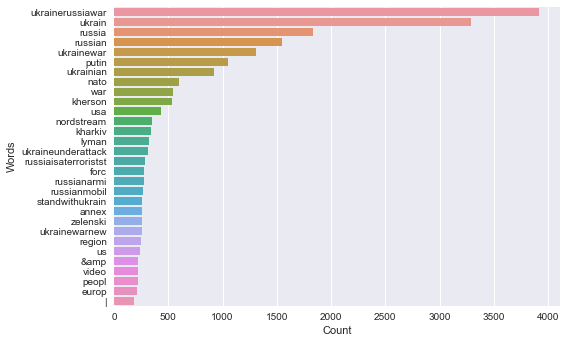

In [31]:
ax = sns.barplot(x=list(word_count.values())[:30], y=list(word_count.keys())[:30])
ax.set(xlabel='Count', ylabel='Words')
plt.savefig("barplot_top10.png")
plt.show()



### Wordcloud plot

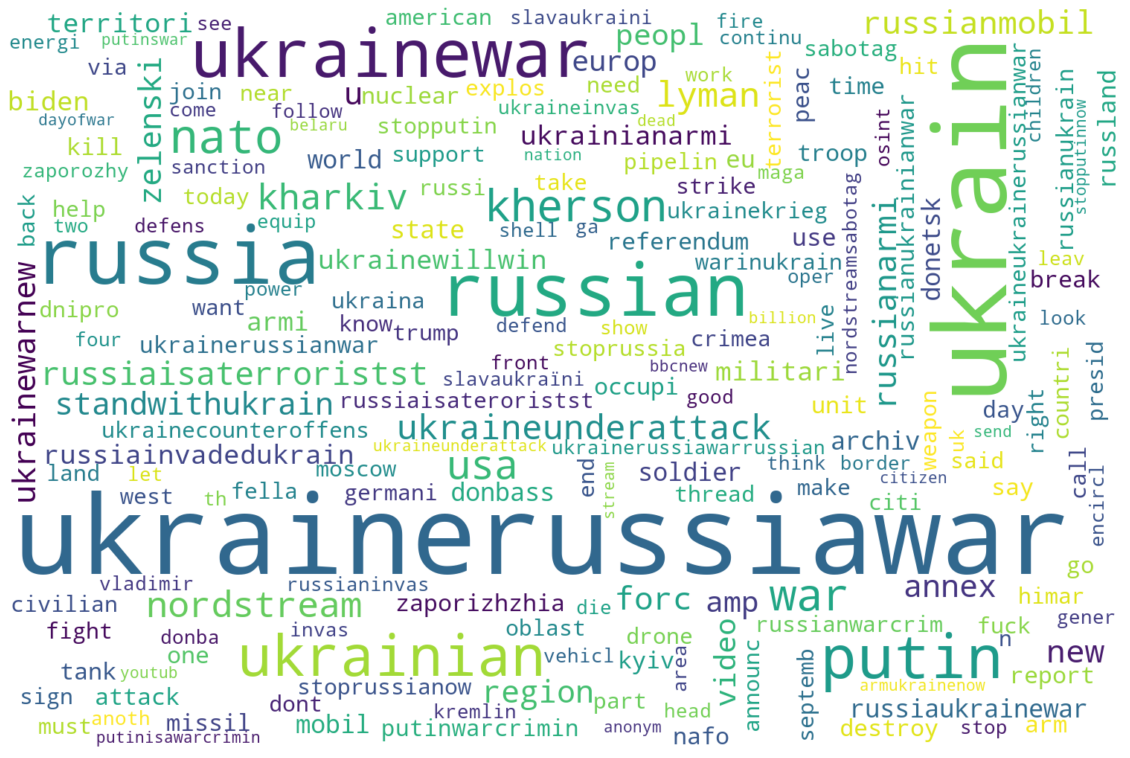

In [26]:
wordcloud = WordCloud(collocations = False,
                      background_color = "white",
                      width = 1500,
                      height = 1000).generate(' '.join(word_list))
plt.figure(figsize = (20, 15))
plt.imshow(wordcloud,
           interpolation = 'bilinear')
plt.axis("off")
plt.savefig("wordcloud.png")
plt.show()

### Histogram of the number of likes

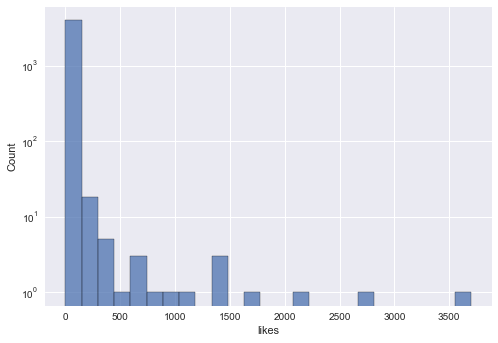

In [32]:
sns.histplot(tweets['likes'], log_scale = (False, True), bins = 25)
plt.savefig("histogram_likes.png")
plt.show()

### Scatter plot likes and retweets 

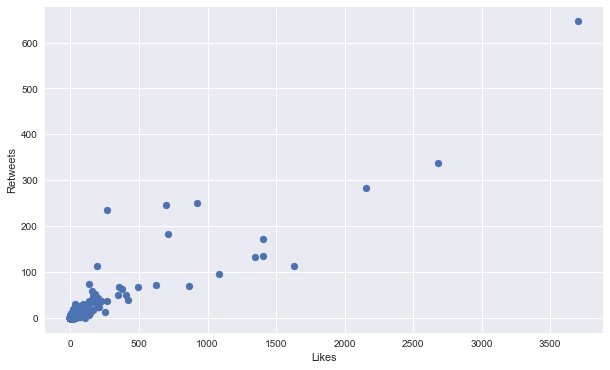

In [33]:
fig, ax = plt.subplots(figsize=(10,6))
ax.scatter(tweets['likes'], tweets['retweets'])
ax.set_xlabel('Likes')
ax.set_ylabel('Retweets')
plt.style.use("seaborn")
plt.savefig("scatter_plot.png")
plt.show()